In [ ]:
! pip install SpaCy
! python -m spacy download es
!pip install pyLDAvis
!pip install kneed
!pip install pretty_html_table
!pip uninstall numpy
!pip install numpy==1.24


2023-09-26 15:32:48.304775: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 15:32:49.135457: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'es' are deprecated. Please use the
full pipeline package name 'es_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 106.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
  Using cached numpy-1.26.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.0
    Uninstalling numpy-1.24.0:
      Successfully uninstalled numpy-1.24.0
ERROR: p

In [ ]:
import pandas as pd
import os
import re
import requests
import itertools

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import  Counter
from spacy.lang.es import stop_words
import gensim
from gensim.matutils import corpus2dense
from gensim.models import CoherenceModel
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from kneed import KneeLocator
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
import pyLDAvis
import pyLDAvis.gensim
from pretty_html_table import build_table
import IPython
import spacy
spacy.cli.download('es_core_news_lg')
%matplotlib inline





✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')


In [ ]:
#trabajamos con el dataset en el que se ha organizado el campo service_code
df = pd.read_excel("/content/train_reclasificado.xlsx")

print(df.columns)
#construyo un campo fecha para un mejor análisis del dataframe
df["requested_datetime"] = df["requested_datetime"].apply(lambda x: x[0:10] )
df["fecha"] =  pd.to_datetime(df["requested_datetime"], format='%Y-%m-%d')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Unnamed: 0.1', 'service_request_id', 'status', 'service_code_ant',
       'service_name_ant', 'title', 'description', 'requested_datetime',
       'updated_datetime', 'address_string', 'address_id', 'long', 'lat',
       'id_cat_sip', 'fecha', 'anyo', 'Unnamed: 0', 'codigo', 'subcodigo',
       'categoria_x', 'subcategoria', 'service_name_y', 'service_code',
       'service_name', 'categoria'],
      dtype='object')


In [ ]:


#compruebo la cantidad de registros del dataframe y que todos los valores del identificador de la reclamación son únicos
print(len(df["service_request_id"].unique()))
print(len(df))

servicios = df.groupby(["service_name", df['fecha'].dt.year], as_index = False).size().sort_values(['fecha', 'size'], ascending=False)

servicios_por_dpto = df.groupby(["service_name"], as_index = False).size().sort_values('size', ascending=False)

output= build_table(servicios, 'blue_light')
IPython.display.HTML(output)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


40094
40594


service_name,fecha,size
Parques y Jardines,2023,2213
Limpieza Pública,2023,1399
Infraestructuras:Conservacion,2023,724
Movilidad Urbana. Transporte Público,2023,667
Policia Local,2023,560
Alumbrado Publico,2023,442
Movilidad Urbana: Señalización,2023,378
Urbanismo,2023,272
Instituto Mpal. Salud Publica,2023,256
Instalaciones Deportivas,2023,239


In [ ]:
#número de reclamaciones realizadas en todo el periodo analizado
output= build_table(servicios_por_dpto, 'blue_light')
IPython.display.HTML(output)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


service_name,size
Parques y Jardines,9285
Limpieza Pública,5850
Infraestructuras:Conservacion,4747
Policia Local,3398
Alumbrado Publico,2785
Movilidad Urbana: Señalización,2372
Urbanismo,1682
Movilidad Urbana. Transporte Público,1278
Instituto Mpal. Salud Publica,847
Cultura,816


In [ ]:




#Aqui desarrollo el proceso de prepocesado del texto y tokenización

def quitar_acentos(old):

    new = old.lower()

    new = re.sub(r'[àáâãäå]', 'a', new)
    new = re.sub(r'[èéêë]', 'e', new)
    new = re.sub(r'[ìíîï]', 'i', new)
    new = re.sub(r'[òóôõö]', 'o', new)
    new = re.sub(r'[ùúûü]', 'u', new)
    new= re.sub(r'[^\w\s]', " ", new)
    return new





def tratar(cadena, nlp, list_corregidas):
    #a,b = 'áéíóúü','aeiouu'
    #trans = str.maketrans(a,b)
    #elimino hiperenlaces
    tratada = re.sub(r'\s{0,}http+s{0,1}\S+\s{1,}', ' ', cadena)
    #elimino signos ortográficos
    tratada= re.sub(r'[^\w\s]', ' ', tratada)
    #quito los números
    tratada= re.sub('[0-9]', ' ', tratada)

    tratada = re.sub(r"\b[A-Z]{1}[a-z]+\b", " ", tratada)
    tratada = tratada.replace("\n", " ")




    list_inicial = tratada.split()

    list_final = [quitar_acentos(palabra)for palabra in list_inicial if palabra]


    if list_corregidas:

      cadena_tratada =   ' '.join(list_final)
      list_tratadas =  [token.lemma_ for token in nlp(cadena_tratada) if not token.is_stop and len(token.lemma_)>2 and token.lemma_ in list_corregidas ]


    else:
      list_final = [quitar_acentos(palabra) for palabra in list_inicial]
      cadena_tratada =   ' '.join(list_final)
      list_tratadas =  [token.lemma_ for token in nlp(cadena_tratada) if not token.is_stop and len(token.lemma_)>2 ]





    tratada = ' '.join(list_tratadas)



    return tratada




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

'''Con este código tenia la intención de limpiar el corpus de palabras con una única aparición,
pero al final decidí ajustar el umbral del diccionario que utilizaré más adelante


#paso los valores de la columna deescripción de la queja a una lista
lst_descripcion = df["description"].tolist()

#aplico la función definida anteriormente para realizar una limpieza de texto
#obtengo una lista de listas
texto_en_bruto = [explorar_corpus(doc) for doc in  lst_descripcion ]

#aqui creo un corpus: lista de todas las palabras después de la limpieza
corpu = [item for row in texto_en_bruto for item in row]

#aqui genero una lista con las palabras y su número de ocurrencias del corpus anterior
counter=Counter(corpu)
most=counter.most_common()
df_common= pd.DataFrame()

x, y= [], []
for word,count in most:

    x.append(word.strip())
    y.append(count)

df_common['palabra'] = x
df_common['ocurrencias'] = y
df_common.to_csv("common_.csv")




#ahora elijo las palabras que aparecen sólo una vez en el corpus
df_ = df_common[df_common["ocurrencias"]==1]

#creo una lista de palabras con una sola ocurrencia
ext_stop_words = df_.palabra.tolist()
print(ext_stop_words[0:10])

cls = spacy.util.get_lang_class('es')
#añando a las stop words de spacy la lista de palabras ext_corp_words
print(len(cls.Defaults.stop_words))

for palabra in ext_stop_words:
  cls.Defaults.stop_words.add(palabra)

print(len(cls.Defaults.stop_words))

#estas son el tipo de palabras que aparecen una única vez, muchas de ellas son equivocaciones
#otras podrían tratarse por spacy pero debido a su poca influencia las elimino.
#otra alternativa sería configurar el diccionario de gensim
output= build_table(df_common[df_common["ocurrencias"]==1].head(20), 'blue_light')
IPython.display.HTML(output)
'''

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Con este códgo tenia la intención de limpiar el corpus de palabras con una única aparición, \npero al final decidí ajustar el umbral del diccionario qur utilizaré más adelante\n\n\n#paso los valores de la columna deescripción de la queja a una lista\nlst_descripcion = df["description"].tolist()\n\n#aplico la función definida anteriormente para realizar una limpieza de texto\n#obtengo una lista de listas\ntexto_en_bruto = [explorar_corpus(doc) for doc in  lst_descripcion ]\n\n#aqui creo un corpus: lista de todas las palabras después de la limpieza\ncorpu = [item for row in texto_en_bruto for item in row]\n\n#aqui genero una lista con las palabras y su número de ocurrencias del corpus anterior\ncounter=Counter(corpu)\nmost=counter.most_common()\ndf_common= pd.DataFrame()\n\nx, y= [], []\nfor word,count in most:\n\n    x.append(word.strip())\n    y.append(count)\n\ndf_common[\'palabra\'] = x\ndf_common[\'ocurrencias\'] = y\ndf_common.to_csv("common_.csv")\n\n\n\n\n#ahora elijo las palabr

In [ ]:

'''
Estas serian las stopwords que quedarían después de incluir todas aquellas que aparecen sólo una vez.
Después de analizarlas, y aunque muchas de ellas eran errores de escritura, decidí ajustar por medio del umbral
del diccionario porque aun siendo una pequeña cantidad me dí cuenta de que algunas de ellas aún eran susceptibles
de ser tokenizadas

#guardo en un archivo para su análisis y posible utilización la lista de stopwords que henos obtenido
stop_word_serie = pd.Series(sorted(cls.Defaults.stop_words))
stop_word_serie.to_csv("stopwords_sp.csv", index = False)
'''

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'\nEstas serian las stopwords que quedarían después de incluir todas aquellas que apraecen sólo una vez.\nDespués de analizarlas, y aunque muchas de ellas eran errores de escritura, decidí ajustar por medio del umbral \ndel diccionario porque aun siendo una pequeña cantidad me dí cuenta de que algunas de ellas aún eran susceptibles\nde ser tokenizadas\n\n#guardo en un archivo para su análisis y posible utilización la lista de stopwords que henos obtenido\nstop_word_serie = pd.Series(sorted(cls.Defaults.stop_words))\nstop_word_serie.to_csv("stopwords_sp.csv", index = False)\n'

In [ ]:
'''
Voy a tratar por primera vez el texto de las quejas
posteriormente revisaré los tokens resultantes de la tokenización
por si hay que eliminar todavía alguna del corpus para mejorarlo y acelerar los procesos de predicción
y volveré a realizar el proceso descartando las palabras eliminadas
'''

#cargo el modelo spacy para el castellano
nlp = spacy.load("es_core_news_lg")

#obtengo una lista de listas de la serie del dataframe
lst_descripcion = df["description"].tolist()

#obtengo otra lista de cadenas con el texto tratado
texto = [tratar(doc,nlp, None)  for doc in  lst_descripcion ]


#incorporo el texto modificado de nuevo a una columna del dataframe
df["texto_tratado_inicial"] = pd.Series(texto)

texting = df["texto_tratado_inicial"].str.split()
print(texting.head(10))


corpus=[[word for word in elem] for elem in texting ]

#creo una lista con todas los tokens de las reclamaciones
corpux = [item for row in corpus for item in row if item]


#generaré una excel para dar un último repaso manual a todas las palabras con más de 100 apariciones
counter=Counter(corpux)
most=counter.most_common()

df_common = pd.DataFrame()

x, y= [], []
for word,count in most:

    x.append(word.strip())
    y.append(count)

df_common['token'] = x
df_common['ocurrencias'] = y
df_common_100 =df_common[df_common['ocurrencias']>100]
df_common_100.to_excel("acorregir.xlsx")

df.to_excel("primer_tratamiento.xlsx")



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    [gente, venir, observar, excesivo, limpieza, c...
1    [arreglar, echar, culpa, incivismo, ciudadano,...
2    [bache, paseo, constitucion, calle, reparacion...
3                    [bache, plaza, reparacion, bache]
4           [bache, calle, cabaldo, reparacion, bache]
5             [bache, calle, calle, reparacion, bache]
6    [calle, unir, empr, lecitrailer, calle, hecho,...
7    [propondriir, limpiar, fondo, zona, estar, lim...
8    [malestar, vecino, calle, lamentable, asfalto,...
9           [bache, avenida, calle, reparacion, bache]
Name: texto_tratado_inicial, dtype: object


In [ ]:

#el archivo listado_corregidas.xlsx se crea a partir de la visualización y edición manual de los registros en acorregir.xlsx
#elimino nombres propios, palabras como calle (que aparecen con mucha frecuencia pero en principio pienso que no aportan mucho)...
corregidas = pd.read_excel("/content/lista_corregidas.xlsx")
print(corregidas.columns)
corregidas = corregidas[corregidas["sino"]==1]
list_corregidas = corregidas["token"].tolist()


nlp = spacy.load("es_core_news_lg")
lst_descripcion = df["description"].tolist()
texto = [tratar(doc,nlp, list_corregidas )  for doc in  lst_descripcion ]

df["texto_tratado"] = pd.Series(texto)

texting = df["texto_tratado"].str.split()
print(texting.head)

#genero una lista de listas para su vectorización
corpus=[[word for word in elem] for elem in texting ]

#y el conjunto de palabras existentes en el campo descripción preprocesado del dataset
corpux = [item for row in corpus for item in row if item]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Unnamed: 0', 'token', 'ocurrencias', 'sino'], dtype='object')
<bound method NDFrame.head of 0        [gente, venir, observar, excesivo, limpieza, c...
1        [arreglar, echar, culpa, ciudadano, cargo, ani...
2                        [bache, paseo, reparacion, bache]
3                        [bache, plaza, reparacion, bache]
4                               [bache, reparacion, bache]
                               ...                        
40589    [escribir, situacion, encontrar, contenedor, a...
40590                        [farola, fundido, punto, luz]
40591    [aspersor, ribera, altura, paseo, agua, tierra...
40592    [semaforo, peatón, direccion, justo, cruce, se...
40593    [parque, menor, haber, riego, roto, aparecer, ...
Name: texto_tratado, Length: 40594, dtype: object>


In [ ]:
#localizo las filas que no tienen texto tokenizado en el campo texto_tratado y las elimino
print(len(df[df['texto_tratado'] == ''])  )
vacios = df[df['texto_tratado'] == '']
vacios.to_excel("vacios.xlsx")
print(len(df))
df.drop(df[df['texto_tratado'] == ''].index, inplace = True)
print(len(df))

#genero un dataframe con los resultados definitivos
df.to_excel("df_limpia.xlsx")
output= build_table(df.head(), 'blue_light')
IPython.display.HTML(output)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


81
40594
40513


Unnamed: 0.1,service_request_id,status,service_code_ant,service_name_ant,title,description,requested_datetime,updated_datetime,address_string,address_id,long,lat,id_cat_sip,fecha,anyo,Unnamed: 0,codigo,subcodigo,categoria_x,subcategoria,service_name_y,service_code,service_name,categoria,texto_tratado_inicial,texto_tratado
0,477390,closed,250,Limpieza viaria,desmesurado gasto de agua,Buenos días\n\nSomos mucha gente que venimos observando el excesivo uso de la limpieza en el centro de Zaragoza\nlimpian con agua una y otra vez incluso cuando está lloviendo. De hecho tenemos videos que así lo demuestran.\n\nEs necesario este derroche de agua???\n\nLa mayoría de gente opinamos que NO\n\nY menos en una ciudad que se tacha de ciudad del agua,2017-01-01,2017-01-11T12:39:21Z,,,,,,2017-01-01,2017,,,,,,Limpieza viaria,4849672,Limpieza Pública,,gente venir observar excesivo limpieza centro limpian agua llover video demostrar necesario derroche agua mayoria gente opinar ciudad tachar ciudad agua,gente venir observar excesivo limpieza centro agua llover video demostrar necesario agua mayoria gente ciudad ciudad agua
1,477389,closed,250,Limpieza viaria,vergonzoso,"Probablemente todo se arregle echando la culpa al incivismo ciudadano , sobre todo de aquellos que tienen a su cargo un animal de compañia. Animal al que sacan a la calle a hacer sus necesidades y que deja las calles echas una vergüenza. Porque aunque creo que el vecindario se ha resignado o acostumbrado a esta estampa, no existe otra palabra para describir el estado de ka limpieza de las calles Segovia, Pradilla, Génova... y seguro que si prestamos atención a cualquier calle cercana el esrado es el mismo. Mierdas de perro que llevan más de 1 semana sin que NADIE hata pasado a limpiarlas no 1 ni 2, ni 3... invito a lis sres alcalde y concejales a que se paseen y disfruten... aceras envejecidas, mobiliario urbano deteriotado, fachadas degradadas... por el pis continuo de perros... ASQUEROSO. Intolerable!! o se limpia a fondo... o se multa a lis dueños... lo que sea... menos que los vecinos sin perro tengamos que aguantarlo!!! gracias\n\npd: no envio adjuntos porque no acabaria. reitero mi invitación a darse un paseo por la zona",2017-01-01,2017-01-24T11:52:27Z,,,,,,2017-01-01,2017,,,,,,Limpieza viaria,4849672,Limpieza Pública,,arreglar echar culpa incivismo ciudadano cargo animal compañia sacar calle necesidad dejar calle echar verguenza vecindario resignar acostumbrado estampa palabra describir limpieza calle genova seguro prestar atencion calle cercano esrado perro llevar semana hatar limpiar él invitar lis sres alcalde concejal pasear disfrutar acera envejecido mobiliario urbano deteriotado fachada degradado pis continuo perro asqueroso limpiar fondo multar dueño vecino perro tener aguantar él gracias enviar adjunto acabario reitero invitacion dar él paseo zona,arreglar echar culpa ciudadano cargo animal sacar necesidad dejar echar verguenza vecindario palabra limpieza seguro prestar atencion cercano perro llevar semana invitar alcalde pasear disfrutar acera mobiliario urbano fachada pis continuo perro asqueroso limpiar fondo multar dueño vecino perro tener enviar paseo
2,477407,closed,61,Bache,Baches en el paseo de la Constitución con la calle Isaac Peral,Hay varios baches en el paseo de la Constitución con la calle Isaac Peral.\nSolicito la reparación de los baches.,2017-01-02,2017-03-20T09:19:25Z,"CONSTITUCION, PASEO, 21",28722.0,-0.882003,41.648265,,2017-01-02,2017,,,,,,Bache,4849669,Infraestructuras:Conservacion,,bache paseo constitucion calle reparacion bache,bache paseo reparacion bache
3,477535,closed,61,Bache,Baches en la plaza San Miguel,Hay varios baches en la plaza San Miguel.\nSolicito la reparación de los baches.,2017-01-03,2017-01-17T12:33:20Z,"SAN MIGUEL, PLAZA, 3",1906.0,-0.875783,41.650017,,2017-01-03,2017,,,,,,Bache,4849669,Infraestructuras:Conservacion,,bache plaza reparacion bache,bache plaza reparacion bache
4,477534,closed,61,Bache,Baches en la calle Migue

In [ ]:
#empezamos a trabajar con el texto de la queja tratado y limpio
df = pd.read_excel("/content/df_limpia.xlsx")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

#obtengo el corpus después de haber eliminado las filas con valores Nan

texting = df["texto_tratado"].str.split()
print(texting.head)

#genero una lista de listas para su vectorización
corpus=[[word for word in elem] for elem in texting ]
print(len(corpus))

#y el conjunto de palabras existentes en el campo descripción del dataset
corpux = [item for row in corpus for item in row if item]
print(len(corpux))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<bound method NDFrame.head of 0        [gente, venir, observar, excesivo, limpieza, c...
1        [arreglar, echar, culpa, ciudadano, cargo, ani...
2                        [bache, paseo, reparacion, bache]
3                        [bache, plaza, reparacion, bache]
4                               [bache, reparacion, bache]
                               ...                        
40508    [escribir, situacion, encontrar, contenedor, a...
40509                        [farola, fundido, punto, luz]
40510    [aspersor, ribera, altura, paseo, agua, tierra...
40511    [semaforo, peatón, direccion, justo, cruce, se...
40512    [parque, menor, haber, riego, roto, aparecer, ...
Name: texto_tratado, Length: 40513, dtype: object>
40513
852899


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


gente venir observar excesivo limpieza centro agua llover video demostrar necesario agua mayoria gen


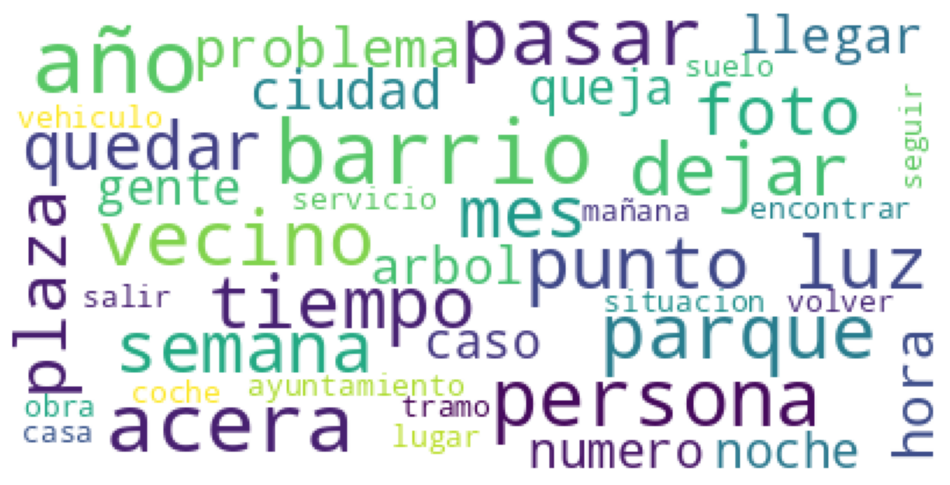

In [ ]:
#aqui realizo una representación wordcloud con las palabras más frecuentes en el corpus

mpl.rcParams['figure.figsize']=(12.0,12.0)
mpl.rcParams['font.size']=12
mpl.rcParams['savefig.dpi']=100
mpl.rcParams['figure.subplot.bottom']=.1
cls = spacy.util.get_lang_class('es')
stopwords = cls.Defaults.stop_words

texto = ' '.join([i for i in df["texto_tratado"]]).split()
texto =  ' '.join(texto)


print(texto[0:100])
#print(corpux[0:100])


wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=40,
                          random_state=42
                         ).generate(str(texto))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


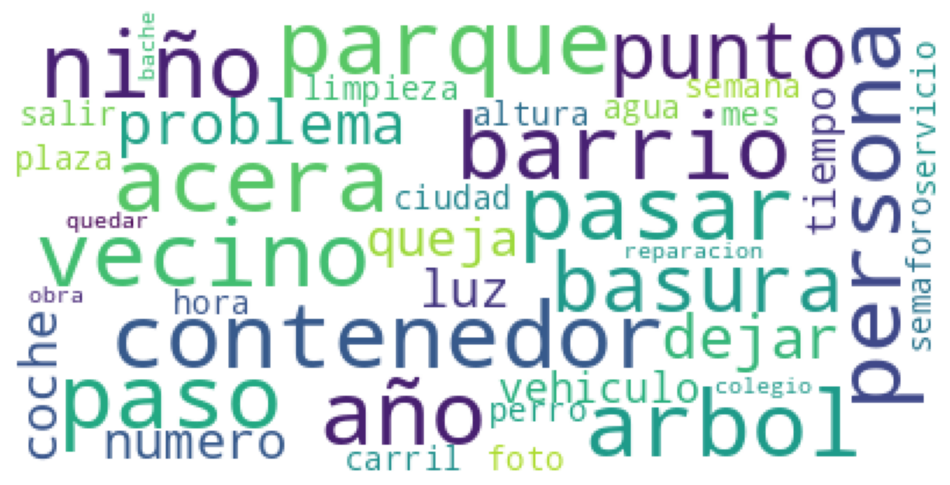

In [ ]:
#vuelvo a representar un wordcloud con las palabras que aparecen más de 500 veces

counter=Counter(corpux)
most=counter.most_common()

df_common = pd.DataFrame()

x, y= [], []
for word,count in most:

    x.append(word.strip())
    y.append(count)
df_common['token'] = x
df_common['ocurrencias'] = y

df_common_500 = df_common[df_common["ocurrencias"]>500]



texto = ' '.join([i for i in df_common_500["token"]]).split()
texto =  ' '.join(texto)




mpl.rcParams['figure.figsize']=(12.0,12.0)
mpl.rcParams['font.size']=12
mpl.rcParams['savefig.dpi']=100
mpl.rcParams['figure.subplot.bottom']=.1
stopwords = cls.Defaults.stop_words

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=40,
                          random_state=42
                         ).generate(str(texto ))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [ ]:
print(corpus[0:10])
print(corpux[0:10])

[['gente', 'venir', 'observar', 'excesivo', 'limpieza', 'centro', 'agua', 'llover', 'video', 'demostrar', 'necesario', 'agua', 'mayoria', 'gente', 'ciudad', 'ciudad', 'agua'], ['arreglar', 'echar', 'culpa', 'ciudadano', 'cargo', 'animal', 'sacar', 'necesidad', 'dejar', 'echar', 'verguenza', 'vecindario', 'palabra', 'limpieza', 'seguro', 'prestar', 'atencion', 'cercano', 'perro', 'llevar', 'semana', 'invitar', 'alcalde', 'pasear', 'disfrutar', 'acera', 'mobiliario', 'urbano', 'fachada', 'pis', 'continuo', 'perro', 'asqueroso', 'limpiar', 'fondo', 'multar', 'dueño', 'vecino', 'perro', 'tener', 'enviar', 'paseo'], ['bache', 'paseo', 'reparacion', 'bache'], ['bache', 'plaza', 'reparacion', 'bache'], ['bache', 'reparacion', 'bache'], ['bache', 'reparacion', 'bache'], ['unir', 'hecho', 'porqueria', 'entrada', 'peligroso', 'trabajador', 'empresa', 'hoja', 'mando', 'foto', 'hora'], ['limpiar', 'fondo', 'estar', 'plaza', 'alrededor'], ['malestar', 'vecino', 'lamentable', 'asfalto', 'grieta', 'p

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:



def plot_top_ngrams_barchart(corpus, serie, n=2):


    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx])
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq

    top_n_bigrams=_get_top_ngram(serie,n)[0:10]
    x,y=map(list,zip(*top_n_bigrams))
    print(x,y)
    sns.barplot(x=y,y=x)



#xplot_top_ngrams_barchart(df["texto"],2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['parque', 'acera', 'año', 'barrio', 'pasar', 'arbol', 'contenedor', 'vecino', 'persona', 'niño'] [8026, 6379, 6028, 5950, 5904, 5180, 4977, 4954, 4792, 4598]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector)

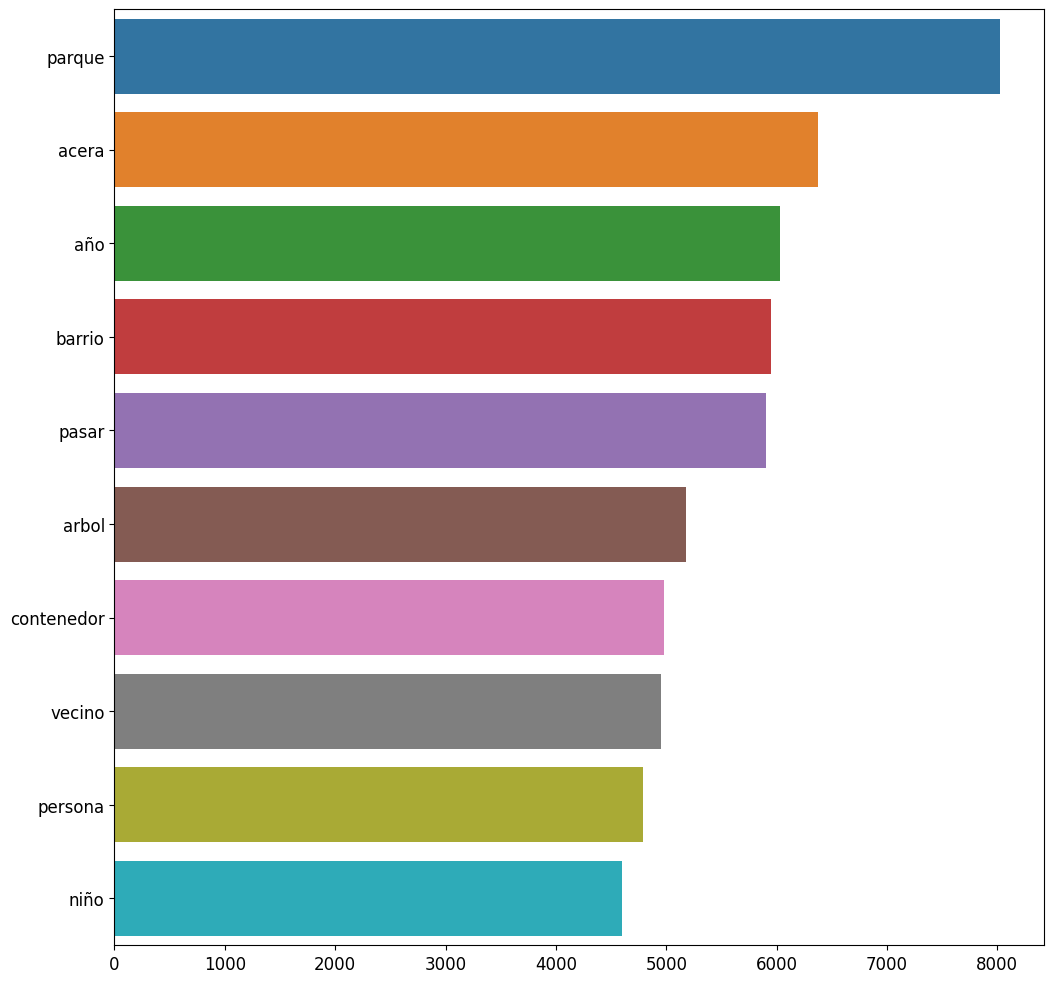

In [ ]:
plot_top_ngrams_barchart(corpux, df["texto_tratado"], 1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['punto luz', 'carril bici', 'reparacion bache', 'paso peatón', 'parque infantil', 'paso cebra', 'tomar medida', 'altura numero', 'policia local', 'bache reparacion'] [2639, 1092, 1059, 1040, 986, 919, 852, 767, 762, 665]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector)

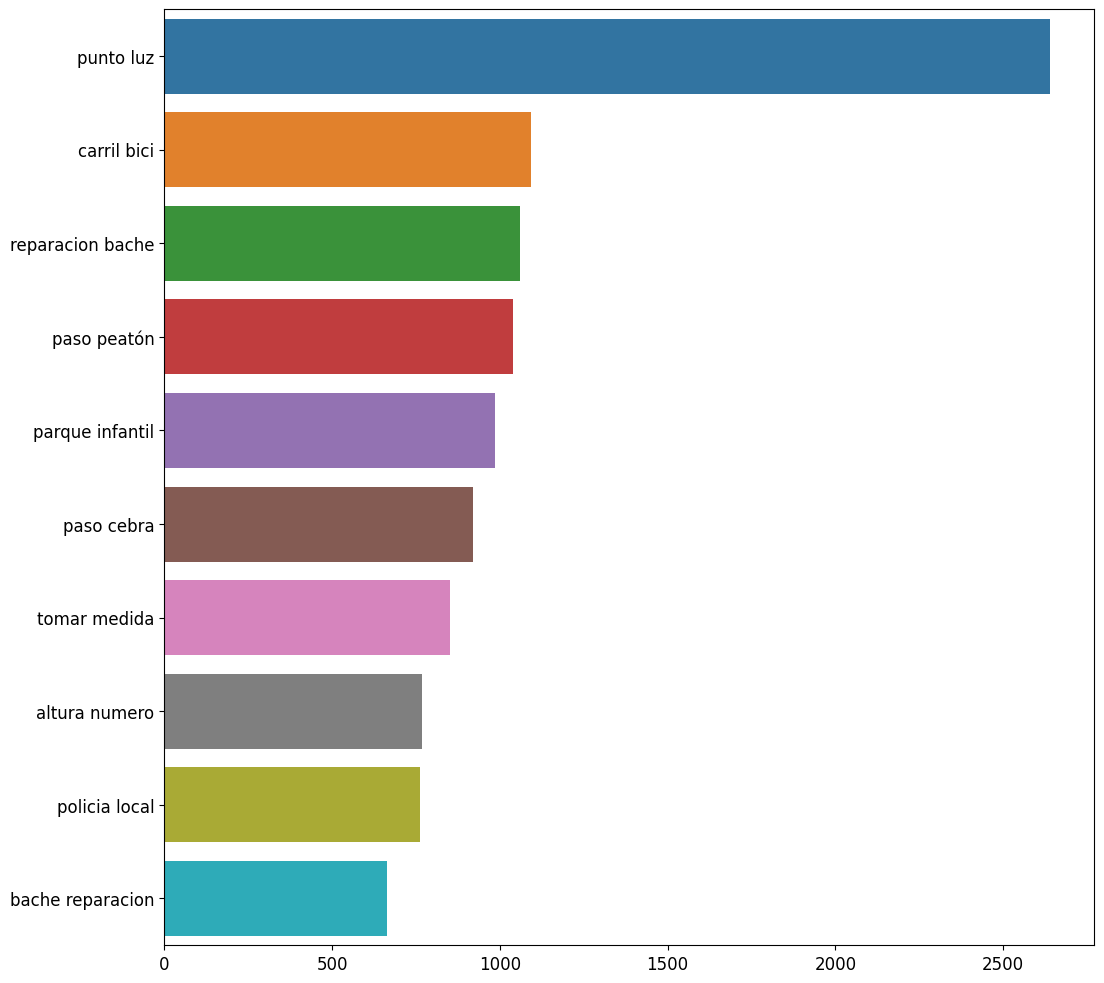

In [ ]:
plot_top_ngrams_barchart(corpux, df["texto_tratado"], 2)

In [ ]:
############################################################################################################################

In [ ]:
def muestra_n_palabras_kmeans(modelo, caracteristicas, n_palabras):
    order_centroids = modelo.cluster_centers_.argsort()[:, ::-1]
    for i in range(modelo.n_clusters):
        print(f'Cluster {i}:')
        for ind in order_centroids[i, :n_palabras]:
            print(f'{caracteristicas[ind]}')
        print()
muestra_n_palabras_kmeans(modelo_kmeans, list(dictionary.token2id.keys()), 10)

Cluster 0:
aparcamiento
aparcar
coche
moto
vehiculo
plaza
estacionamiento
aparcado
garaje
acera

Cluster 1:
contenedor
basura
cubo
lleno
papel
recogida
organico
bolsa
vidrio
reciclaje

Cluster 2:
vertical
señal
señalizacion
reparacion
derribado
inclinado
paseo
posicion
girar
correcto

Cluster 3:
luz
punto
farola
apagado
fundido
alumbrado
fundida
noche
funcionar
encender

Cluster 4:
parque
infantil
niño
perro
columpio
juego
roto
fuente
jugar
cesped

Cluster 5:
semaforo
fundido
reparacion
paseo
posicion
jose
correcto
conductor
maria
roto

Cluster 6:
paso
carril
acera
peatón
baldosa
vehiculo
señal
bici
calzada
semaforo

Cluster 7:
arbol
rama
poda
podar
tapar
plantar
situado
caer
año
seco

Cluster 8:
bache
reparacion
paseo
jose
plaza
maria
via
puente
solicito
agustin

Cluster 9:
agua
barrio
limpieza
año
vecino
pasar
servicio
tarde
persona
queja



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
modelo_lda_sklearn = LatentDirichletAllocation(n_components=20).fit(resultado_tfidf_sklearn)
modelo_kmeans_2 = KMeans(n_clusters=7)
clusters_2 = modelo_kmeans_2.fit_predict(resultado_tfidf_sklearn)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(modelo_lda_sklearn, resultado_tfidf_sklearn , modelo_tfidf_sklearn)
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: ignored

In [ ]:
def from_sklearn(docs,vect,lda,**kwargs):

    """Create Prepared Data from sklearn's vectorizer and Latent Dirichlet
    Application

    Parameters
    ----------
    docs : Pandas Series.
        Documents to be passed as an input.
    vect : Scikit-Learn Vectorizer (CountVectorizer,TfIdfVectorizer).
        vectorizer to convert documents into matrix sparser
    lda  : sklearn.decomposition.LatentDirichletAllocation.
        Latent Dirichlet Allocation

    **kwargs: Keyword argument to be passed to pyLDAvis.prepare()


    Returns
    -------
    prepared_data : PreparedData
    vect : sklearn's Vectorizer.
    lda : sklearn's Latent Dirichlet Allocation.
    """

    norm = lambda data: pd.DataFrame(data).div(data.sum(1),axis=0).values

    vected = vect.fit_transform(docs)
    doc_topic_dists = norm(lda.fit_transform(vected))

    prepared = prepare(
                        doc_lengths = docs.str.len(),
                        vocab = vect.get_feature_names(),
                        term_frequency = vected.sum(axis=0).tolist()[0],
                        topic_term_dists = norm(lda.components_),
                        doc_topic_dists = doc_topic_dists,
                        **kwargs)

    return prepared,lda,vect

In [ ]:
def muestra_n_palabras_topics(modelo, caracteristicas, n_palabras):
    for idx, topic in enumerate(modelo.components_):
        print(f"Topic {idx}:")

        lista_palabras_topic = \
            [caracteristicas[i] for i in
             topic.argsort()[:-n_palabras - 1:-1]]
        print(" ".join(lista_palabras_topic))

muestra_n_palabras_topics(modelo_lda_sklearn, modelo_bow_sklearn.get_feature_names_out(), 10)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: ignored

In [ ]:
muestra_n_palabras_kmeans(modelo_kmeans_2, modelo_tfidf_sklearn.get_feature_names_out(), 10)

In [ ]:

print([' '.join(doc) for doc in corpus][0:10])
modelo_tfidf_sklearn = TfidfVectorizer(max_df=0.5, min_df=5, use_idf=True)
resultado_tfidf_sklearn = modelo_tfidf_sklearn.fit_transform([' '.join(doc) for doc in corpus])
#print((resultado_bow_sklearn.shape, resultado_tfidf_sklearn.shape))
print((resultado_tfidf_sklearn.shape))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['gente venir observar excesivo limpieza centro agua llover video demostrar necesario agua mayoria gente ciudad ciudad agua', 'arreglar echar culpa ciudadano cargo animal sacar necesidad dejar echar verguenza vecindario palabra limpieza seguro prestar atencion cercano perro llevar semana invitar alcalde pasear disfrutar acera mobiliario urbano fachada pis continuo perro asqueroso limpiar fondo multar dueño vecino perro tener enviar paseo', 'bache paseo reparacion bache', 'bache plaza reparacion bache', 'bache reparacion bache', 'bache reparacion bache', 'unir hecho porqueria entrada peligroso trabajador empresa hoja mando foto hora', 'limpiar fondo estar plaza alrededor', 'malestar vecino lamentable asfalto grieta profundo suelto asegurar asfaltado deberiar tomar medida urgente cara echar algun tiempo necesitar tirado', 'bache reparacion bache']
(40027, 1697)


In [ ]:
print(len(df))
print(len(corpus))

40027
40027


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#trabajamos con el dataset en el que se ha organizado el campo service_code
df_test = pd.read_excel("/content/test.xlsx")
print(len(df_test))
print(df_test.columns)
df_test["requested_datetime"] = df_test["requested_datetime"].apply(lambda x: x[0:10] )
df_test["fecha"] =  pd.to_datetime(df_test["requested_datetime"], format='%Y-%m-%d')

output= build_table(df_test[0:10], 'blue_light')

#IPython.display.HTML(output)


425
Index(['service_request_id', 'status', 'service_code', 'service_name', 'title',
       'description', 'requested_datetime', 'updated_datetime',
       'address_string', 'address_id', 'long', 'lat'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#print(df.columns)


#para reclasificar los servicios en test utilizamos los service_code del dataset train_reclasificado
clasificacion_servicios = df[['service_code', 'service_name', 'service_code_ant']].drop_duplicates()
print(clasificacion_servicios.head)
#print(len(clasificacion_servicios))

#de esta lista para clasificar eliminamos aquellos service_code que corresponden a departamentos finales
#obteniendo el service_code, service_name y subcodigo (codigo sin clasificar)


clasificacion_servicios.subcodigo = clasificacion_servicios.service_code_ant.fillna(0)
clasificacion_servicios.to_excel("clasificacion_servicios.xlsx")
'''
clasificacion_servicios.subcodigo = clasificacion_servicios[['service_code', 'subcodigo']].apply(lambda x: x.service_code if x.subcodigo == 0 else x.subcodigo, axis = 1 )
'''
print("hola",len(clasificacion_servicios.subcodigo))

print(clasificacion_servicios.dtypes)
#clasificacion_servicios = pd.unique(df[['service_code', 'service_name', 'nuevo_codigo']])


<bound method NDFrame.head of        service_code                                       service_name  \
0           4849672                                   Limpieza Pública   
2           4849669                      Infraestructuras:Conservacion   
8           4849669                      Infraestructuras:Conservacion   
14          4849672                                   Limpieza Pública   
15          4849669                      Infraestructuras:Conservacion   
...             ...                                                ...   
20901       1000029  Oficina Jurídica de Servicios Públicos y Movil...   
22505            94                                 Defecto en arqueta   
23823            93                              Falta tape de arqueta   
27027       1000028                                           Igualdad   
33113       1000030                                         Tributaria   

       service_code_ant  
0                   250  
2                    61  
8  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-35-1070326431e6>:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  clasificacion_servicios.subcodigo = clasificacion_servicios.service_code_ant.fillna(0)


In [ ]:
#con_codigox.rename(columns={'nuevo_codigo': 'service_code', 'categoria_y': 'service_name', 'categoria_x': 'categoria'})
clasificacion_servicios = pd.read_excel("/content/clasificacion_servicios.xlsx")



print(df_test.service_code.dtype)


print(clasificacion_servicios.service_code[0:10])



df_test = pd.merge(df_test, clasificacion_servicios, how = "left", left_on = "service_code", right_on = "service_code_ant" )
print(df_test.columns)
df_test.rename(columns={'service_code_y': 'service_code', 'service_name_y': 'service_name' }, inplace = True)
print(df_test.columns)
#df_test.drop(['service_code'], axis = 1, inplace = True)
df_test.to_excel("df_test.xlsx")
'''
print(len(df_test))
print(df_test.columns)
df_test.rename(columns={'service_code_y': 'service_code', 'service_name_y': 'service_name' })
df_test.rename(columns={'nuevo_codigo': 'service_code', 'service_name': 'service_name_original' })
df_test.rename(columns={'categoria': 'service_name'})
'''


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


int64
0    4849672
1    4849669
2    4849669
3    4849672
4    4849669
5    5144577
6    4849672
7    1000000
8    1000000
9    1000000
Name: service_code, dtype: int64
Index(['service_request_id', 'status', 'service_code_x', 'service_name_x',
       'title', 'description', 'requested_datetime', 'updated_datetime',
       'address_string', 'address_id', 'long', 'lat', 'fecha', 'Unnamed: 0',
       'service_code_y', 'service_name_y', 'service_code_ant'],
      dtype='object')
Index(['service_request_id', 'status', 'service_code_x', 'service_name_x',
       'title', 'description', 'requested_datetime', 'updated_datetime',
       'address_string', 'address_id', 'long', 'lat', 'fecha', 'Unnamed: 0',
       'service_code', 'service_name', 'service_code_ant'],
      dtype='object')


"\nprint(len(df_test))\nprint(df_test.columns)\ndf_test.rename(columns={'service_code_y': 'service_code', 'service_name_y': 'service_name' })\ndf_test.rename(columns={'nuevo_codigo': 'service_code', 'service_name': 'service_name_original' })\ndf_test.rename(columns={'categoria': 'service_name'})\n"

In [ ]:


#el archivo listado_corregidas.xlsx se crea a partir de la visualización y edición manual de los registros en acorregir.xlsx
#elimino nombre propios, palabras como calle (que aparecen con mucha frecuencaa peroen principio pienso que no aportan mucho)...
print(corregidas.head)


nlp = spacy.load("es_core_news_lg")
lst_descripcion_test = df_test["description"].tolist()
texto_test = [tratar(doc,nlp, list_corregidas )  for doc in  lst_descripcion_test ]

df_test["texto_tratado"] = pd.Series(texto_test)



#localizo las filas que no tienen texto tokenizado en el campo texto_tratado y las elimino
print(len(df_test[df_test['texto_tratado'] == ''])  )
vacios_test = df_test[df_test['texto_tratado'] == '']
vacios_test.to_excel("vacios_test.xlsx")
print(len(df_test))
df_test.drop(df_test[df_test['texto_tratado'] == ''].index, inplace = True)
print(len(df_test))

texting_test = df_test["texto_tratado"].str.split()
print(texting_test.head)

#genero una lista de listas para su vectorización
corpus_test=[[word for word in elem] for elem in texting_test ]

#y el conjunto de palabras existentes en el campo descripción del dataset
corpux_test = [item for row in corpus_test for item in row if item]


#genero un dataframe con los resultados definitivos
df_test.to_excel("df_test_limpia.xlsx")
output= build_table(df_test.head(), 'blue_light')
IPython.display.HTML(output)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<bound method NDFrame.head of       Unnamed: 0          token  ocurrencias  sino
3              3         parque         7869     1
5              5          acera         6184     1
6              6         barrio         5911     1
7              7          pasar         5851     1
8              8            año         5800     1
...          ...            ...          ...   ...
1746        1746          siglo          101     1
1747        1747         apoyar          101     1
1748        1748  inconveniente          101     1
1749        1749       picadura          101     1
1750        1750      reservado          101     1

[1698 rows x 4 columns]>
2
425
423
<bound method NDFrame.head of 0      [tambor, año, valla, obra, riesgo, caida, aire...
1      [paseo, arbol, levantar, acera, raiz, riesgo, ...
2      [deberiar, valorar, tanto, año, existir, pista...
3      [bajar, puerta, luz, direccion, fuente, farola...
4      [llamar, policia, animal, llamar, especie, pro...
       

service_request_id,status,service_code_x,service_name_x,title,description,requested_datetime,updated_datetime,address_string,address_id,long,lat,fecha,Unnamed: 0,service_code,service_name,service_code_ant,texto_tratado
775031,open,1000009,"Movilidad Urbana: Badenes, Movilidad en Obras",Calle acorazado potemkin,"En la calle acorazado potemkin entre la calle el tambor de hojalata y la calle El séptimo sello hay desde hace casi un año unas vallas de obra con el riesgo de caída y más con el aire, da la sensación como que es el delimitando algún tipo de caída de materiales de fachadas desde este invierno.\nAbandono total. Adjunto foto.",2023-09-01,2023-09-04T06:46:14Z,,,,,2023-09-01,10667,1000009,"Movilidad Urbana: Badenes, Movilidad en Obras",1000009,tambor año valla obra riesgo caida aire sensacion algun tipo caida material fachada invierno foto
775029,open,1403,PAVIMENTO RAICES,Vadorrey,"En vadorrey en el paseo de la rivera con calle Jesús Burriel Alias hay un árbol que está levantando toda la acera con las raíces además de ser muy frondoso con riesgo quizás de desplome.\nAdjunto foto marcando la zona,justo a un banco.",2023-09-01,2023-09-04T06:45:29Z,,,,,2023-09-01,1360,4849671,Parques y Jardines,1403,paseo arbol levantar acera raiz riesgo foto marcar justo banco
775027,closed,1000012,Zaragoza Deporte,Pista multideporte Carlos Val en Valdespartera.,"Deberían de valorar después de tantos años existiendo la pista multideporte Carlos Val en el barrio de Valdespartera en la zona de calle Belle epoque,Volver a empezar y plaza Bambola,zona muy frecuentada y que en nada que cambie la hora no se puede hacer uso.\nLa contestación que recibo hace más de 5 años es que no hay partida presupuestaria,pero mi pregunta es: y no se podría hacer como en el potrero de Arcosur,barrio vecino,poner encendido por tiempo o algo?",2023-09-01,2023-09-05T06:06:35Z,,,,,2023-09-01,10437,1000012,Zaragoza Deporte,1000012,deberiar valorar tanto año existir pista barrio empezar plaza frecuentado cambiar hora contestacion recibir año pregunta potrero barrio vecino encendido tiempo
775026,closed,1000012,Zaragoza Deporte,Valdespartera,"En avenida Casablanca bajando desde puerta de la luz dirección fuente de la Junquera hay unas cuantas farolas en ambos sentidos fundidas y también en la calle Viridiana con calle la gran ilusión hay alguna farola fundida desde hace días.\nEn la manzana de calle belle epoque ,con volver a empezar con plaza bambola hay farolas fundidas.\nEn general en los barrios del sur hay muchas farolas fundidas o ocultas con árboles.\n\nTambién deberían de valorar después de tantos años existiendo la pista multideporte Carlos Val en el barrio de Valdespartera en la zona de calle Belle epoque,Volver a empezar y plaza Bambola,zona muy frecuentada y que en nada que cambie la hora no se puede hacer uso.\nLa contestación que recibo hace más de 5 años es que no hay partida presupuestaria,pero mi pregunta es: y no se podría hacer como en el potrero de Arcosur,barrio vecino,poner encendido por tiempo o algo?\nMatricula del punto de luz:",2023-09-01,2023-09-11T06:48:07Z,,,,,2023-09-01,10437,1000012,Zaragoza Deporte,1000012,bajar puerta luz direccion fuente farola sentido fundida farola fundido manzana volver empezar plaza farola fundida general barrio sur farola fundida arbol deberiar valorar tanto año existir pista barrio empezar plaza frecuentado cambiar hora contestacion recibir año pregunta potrero barrio vecino encendido tiempo punto luz
775025,closed,5144579,Instituto Mpal. Salud Publica,Paloma herida,"Hola buenas hoy hemos llamado a la policia por un animal herido y nos han dicho que no estan para esas tonterías, hemos llamado al 112 y nos han dicho que la especie no era protegida y que no podian hacer nada.\nEl animal era una paloma y ha sufrido durante dos horas en el suelo agonizando, he intentado reanimarla y pedir ayuda y nadie ha querido venir por lo menos para ver como estaba e intentar tomar una decisión para que ningun animal sufra. Pero c

In [ ]:

resultado_tfidf_sklearn_test = modelo_tfidf_sklearn.transform([' '.join(doc) for doc in corpus_test])
print( resultado_tfidf_sklearn_test.shape)

(423, 1697)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

print(corpus[0:10])

texting = df["texto_tratado"].str.split()


#genero una lista de listas para su vectorización
corpus=[[word for word in elem] for elem in texting ]
print(corpus[0:10])
print(len(corpus))










/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['gente', 'venir', 'observar', 'excesivo', 'limpieza', 'centro', 'agua', 'llover', 'video', 'demostrar', 'necesario', 'agua', 'mayoria', 'gente', 'ciudad', 'ciudad', 'agua'], ['arreglar', 'echar', 'culpa', 'ciudadano', 'cargo', 'animal', 'sacar', 'necesidad', 'dejar', 'echar', 'verguenza', 'vecindario', 'palabra', 'limpieza', 'seguro', 'prestar', 'atencion', 'cercano', 'perro', 'llevar', 'semana', 'invitar', 'alcalde', 'pasear', 'disfrutar', 'acera', 'mobiliario', 'urbano', 'fachada', 'pis', 'continuo', 'perro', 'asqueroso', 'limpiar', 'fondo', 'multar', 'dueño', 'vecino', 'perro', 'tener', 'enviar', 'paseo'], ['bache', 'paseo', 'reparacion', 'bache'], ['bache', 'plaza', 'reparacion', 'bache'], ['bache', 'reparacion', 'bache'], ['bache', 'reparacion', 'bache'], ['unir', 'hecho', 'porqueria', 'entrada', 'peligroso', 'trabajador', 'empresa', 'hoja', 'mando', 'foto', 'hora'], ['limpiar', 'fondo', 'estar', 'plaza', 'alrededor'], ['malestar', 'vecino', 'lamentable', 'asfalto', 'grieta', 'p

In [ ]:



from sklearn import linear_model
from sklearn import metrics
modelo_tfidf_sklearn = TfidfVectorizer(max_df=0.5, min_df=5, use_idf=True)
xtrain =modelo_tfidf_sklearn.fit_transform([' '.join(doc) for doc in corpus])

xtest = modelo_tfidf_sklearn.transform([' '.join(doc) for doc in corpus_test])
model = linear_model.LogisticRegression(solver='lbfgs',max_iter=10000)
print(len(df))
print(xtrain.shape[0])
print(len(df.service_code))
model.fit(xtrain, df.service_code)

preds = model.predict(xtest)

print(preds[0:10], print(df_test.service_code[0:10]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


40027
40027
40027


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


0    1000009
1    4849671
2    1000012
3    1000012
4    5144579
5    9043968
6    9043968
7        310
8    4849671
9        120
Name: service_code, dtype: int64
[5144587 4849671 1000012 5144577 5144579 9043968 5144587 4849672     170
     120] None


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(df_test.service_code,preds)
print(confusion_mat)
from sklearn.metrics import classification_report


print(classification_report(preds, df_test.service_code))

[[10  2  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]]
              precision    recall  f1-score   support

          10       0.45      0.77      0.57        13
          20       0.00      0.00      0.00         2
          30       0.00      0.00      0.00         1
          50       0.00      0.00      0.00         0
          60       0.00      0.00      0.00         4
          70       0.00      0.00      0.00         0
          85       0.00      0.00      0.00         1
          90       0.50      0.67      0.57         3
          91       0.50      1.00      0.67         1
          95       0.00      0.00      0.00         0
          97       0.00      0.00      0.00         0
         110       0.00      0.00      0.00         1
         120       0.50      0.88      0.64        16
         170       0.00      0.00      0.00        10
         180       0.22      1.00

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future